In [45]:
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Temperaturen u, m, o
# Wassermenge: uw, mw, ow
waermekapazitaet_J_kg_K = 4190
dusch_temperatur_min_C = 40.0 # minimale Temperatur zum Duschen
heiz_temperatur_min_C = 35.0 # minimale Temperatur zum Heizen

dezentral_wasser_total_kg = 690
uw = dezentral_wasser_total_kg * 10.0/30.0 # diese Faktoren sind gewaehlt in Anlehnung an das Volumen bei den Sensoren
mw = dezentral_wasser_total_kg * 10.0/30.0 # diese Faktoren sind gewaehlt in Anlehnung an das Volumen bei den Sensoren
ow = dezentral_wasser_total_kg * 10.0/30.0 # diese Faktoren sind gewaehlt in Anlehnung an das Volumen bei den Sensoren

u_max_C = 45.0
m_max_C = 65.0
o_max_C = 65.0

def energie_baden_J(u, m, o):
    global uw, mw, ow, dusch_temperatur_min_C, waermekapazitaet_J_kg_K
    if o > dusch_temperatur_min_C:
        energie_u_J = (u-dusch_temperatur_min_C)*uw*waermekapazitaet_J_kg_K
        energie_m_J = (m-dusch_temperatur_min_C)*mw*waermekapazitaet_J_kg_K
        energie_o_J = (o-dusch_temperatur_min_C)*ow*waermekapazitaet_J_kg_K
        energie_J = max(energie_u_J, 0) + max(energie_m_J, 0) + max(energie_o_J, 0)
    else:
        energie_J = (o-dusch_temperatur_min_C) * (uw+mw+ow) * waermekapazitaet_J_kg_K
    return energie_J

maximale_energie_duschen_J = energie_baden_J(u_max_C, m_max_C, o_max_C)

def fuellgrad_baden_prozent(u, m, o):
    global maximale_energie_duschen_J
    ladestand_0_prozent_J = energie_baden_J(0, 40, 50) # es beraucht diese Energie um eine Badewanne zu fuellen
    prozent = (energie_baden_J(u, m, o)-ladestand_0_prozent_J)/(maximale_energie_duschen_J-ladestand_0_prozent_J)*100.0
    return prozent

def energie_heizen_J(u, m, o):
    global uw, mw, ow, heiz_temperatur_min_C, waermekapazitaet_J_kg_K
    if m > heiz_temperatur_min_C:
        energie_u_J = (u-heiz_temperatur_min_C)*uw*waermekapazitaet_J_kg_K
        energie_m_J = (m-heiz_temperatur_min_C)*mw*waermekapazitaet_J_kg_K*0.5 # 0.5 weil nur der halbe Wasserbereich fuers Heizen gebraucht werden kann
        energie_J = max(energie_u_J, 0) + max(energie_m_J, 0)
    else:
        energie_J = (m-heiz_temperatur_min_C) * (uw+mw) * waermekapazitaet_J_kg_K
    return energie_J

def fuellgrad_heizen_prozent(u, m, o):
    prozent = energie_heizen_J(u, m, o)/energie_heizen_J(45, 65, o) * 100.0
    return prozent

def fuellgrad_dezentral_prozent(u, m, o):
    faktor_heizen = 1.0 # damit das Heizen wenig Einfluss hat, nur fall die Heizreserven unter null sind, z.B. 2 bis 5
    heizen =  fuellgrad_heizen_prozent(u, m, o)
    baden =  fuellgrad_baden_prozent(u, m, o)
    return min(heizen, baden)

In [47]:
print(fuellgrad_dezentral_prozent(45, 65, 100))

100.0


In [48]:
import numpy as np
import matplotlib.pyplot as plt

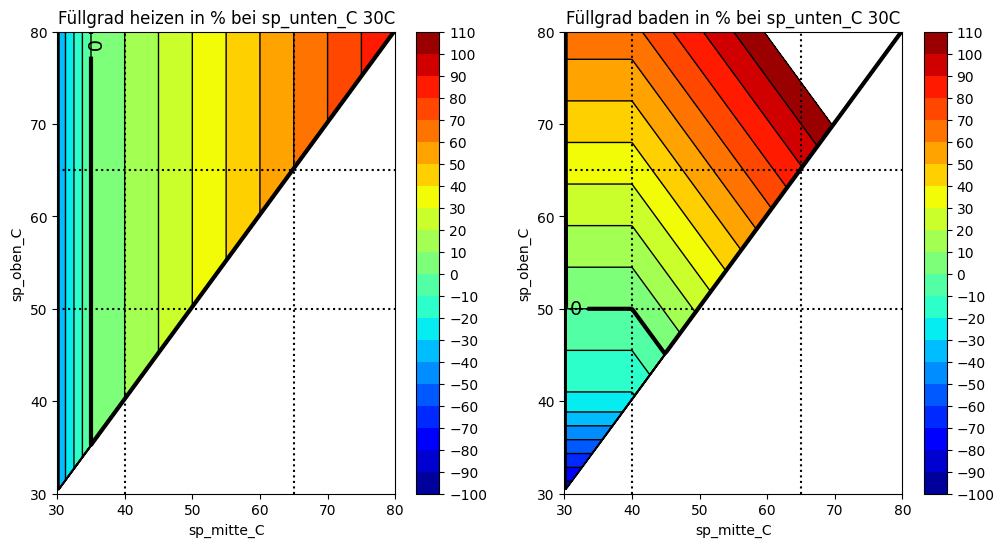

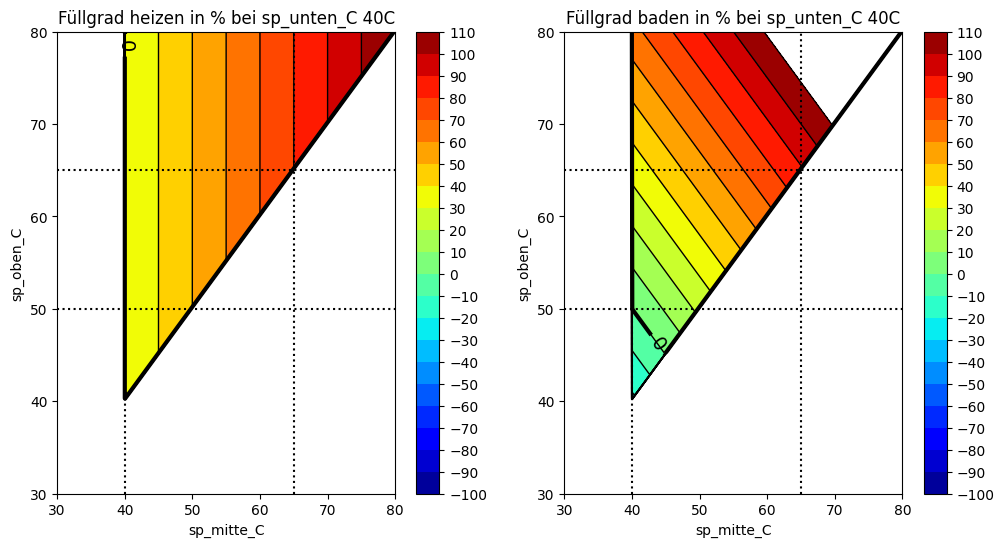

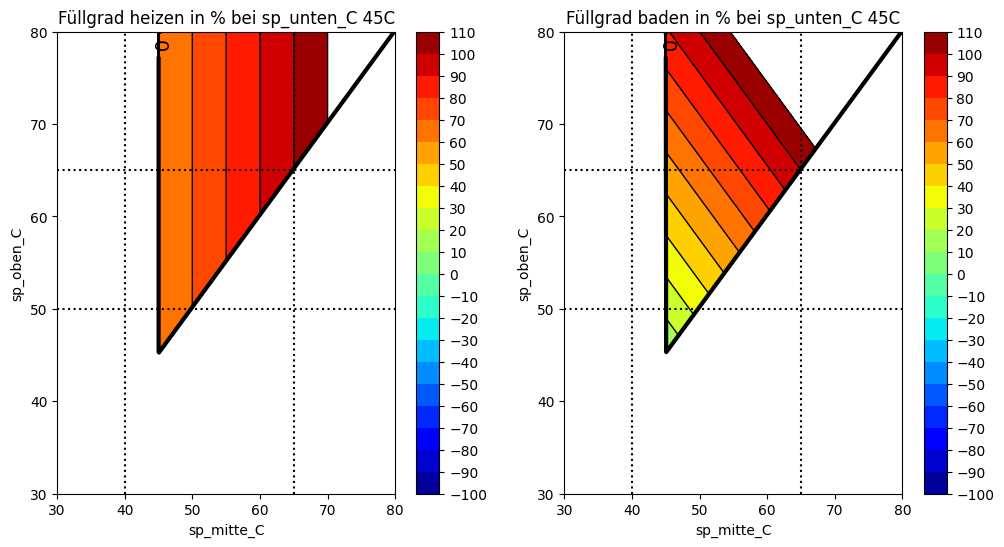

In [49]:
mitte_linspace = np.linspace(30, 80, 200) 
oben_linspace = np.linspace(30, 80, 200)

Z = np.zeros((len(mitte_linspace), len(oben_linspace)))

levels = np.linspace(-100, 110, 22) 

for dezentral_unten_C in [30, 40, 45]:
    #fig,ax=plt.subplots(1,1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6)) # 1 Reihe, 2 Spalten

    durchlauf = ['heizen','baden']

    for ax, durchlauf in zip(axs,durchlauf):

        for i, mitte in enumerate(mitte_linspace):
            for j, oben in enumerate(oben_linspace):
                if mitte > dezentral_unten_C and oben > mitte:
                    if durchlauf == 'heizen':
                        Z[j, i] = fuellgrad_heizen_prozent(dezentral_unten_C, mitte, oben)
                    else:
                        Z[j, i] = fuellgrad_baden_prozent(dezentral_unten_C, mitte, oben)
                else:
                    Z[j, i] = -200.0 # nicht moeglich

        cp = ax.contourf(mitte_linspace, oben_linspace, Z, levels=levels,cmap='jet') # cmap: https://matplotlib.org/stable/users/explain/colors/colormaps.html
        cbar = fig.colorbar(cp, extend='min')
        cbar.set_ticks(levels)
        #fig.colorbar(cp) # Add a colorbar to a plot

        ax.set_xticks(range(20, 90, 10))
        ax.set_yticks(range(20, 90, 10))

        contour1 = ax.contour(mitte_linspace, oben_linspace, Z, levels=[0], colors='black', linestyles='solid', linewidths=3)
        #contour2 = ax.contour(mitte_linspace, oben_linspace, Z, levels=[100], colors='black', linestyles='solid', linewidths=1)
        plt.clabel(contour1, inline=True, fontsize=14)
        #plt.clabel(contour2, inline=True, fontsize=8)

        for level in levels:
            contour = ax.contour(mitte_linspace, oben_linspace, Z, levels=[level], colors='black', linestyles='solid', linewidths=1)
            #plt.clabel(contour, inline=True, fontsize=10)


        ax.axhline(y=50, color='black', linestyle='dotted')
        ax.axhline(y=65, color='black', linestyle='dotted')
        ax.axvline(x=40, color='black', linestyle='dotted')
        ax.axvline(x=65, color='black', linestyle='dotted')
        if durchlauf == 'heizen':
            ax.set_title(f'Füllgrad heizen in % bei sp_unten_C {dezentral_unten_C}C', fontsize=12)
        else:
            ax.set_title(f'Füllgrad baden in % bei sp_unten_C {dezentral_unten_C}C', fontsize=12)
        
        ax.set_xlabel('sp_mitte_C')
        ax.set_ylabel('sp_oben_C')
    plt.show()

In [50]:
# http://maerki.com:3000/d/fh7gxF_Vk/puenterswis?orgId=1&refresh=5s&from=1708795216278&to=1711387216278&viewPanel=14
# Zelglitrasse 53

with open("20240325_raw_temperature_data.txt") as inp:
    data=  np.transpose(list(zip(*(line.strip().split('\t') for line in inp)))) 

In [51]:
data.shape[0], data.shape[1]

(1418, 4)

In [52]:
t = range(data.shape[0])
ulist = np.zeros(data.shape[0])
mlist = np.zeros(data.shape[0])
olist = np.zeros(data.shape[0])
heizen_list = np.zeros(data.shape[0])
baden_list = np.zeros(data.shape[0])
for i, liste in zip(t, data):
    ulist[i]=float(liste[1])
    mlist[i]=float(liste[2])
    olist[i]=float(liste[3])
    u=float(liste[1])
    m=float(liste[2])
    o=float(liste[3])
    heizen_list[i] = fuellgrad_heizen_prozent(u, m, o)
    baden_list[i] = fuellgrad_baden_prozent(u, m, o)


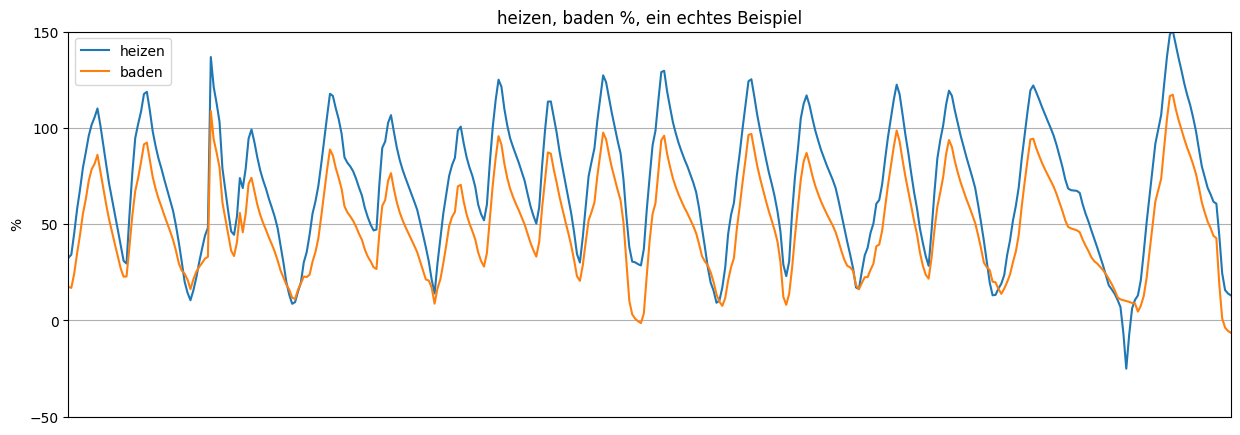

In [64]:
plt.rcParams['figure.figsize'] = [15, 5]
fig2, ax2 = plt.subplots()

ax2.plot(t, heizen_list, label='heizen')
ax2.plot(t, baden_list, label='baden')
ax2.legend()

ax2.set(xlabel='', ylabel='%',
       title='heizen, baden %, ein echtes Beispiel')
ax2.grid(axis='y')
y_grid_levels = [-50, 0, 50, 100, 150]
ax2.set_ylim(min(y_grid_levels), max(y_grid_levels))
ax2.set_yticks(y_grid_levels)

ax2.set_xlim(800, 1200)

ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.show()

In [54]:
import datetime

for liste in data:
    seconds = int(float((liste[0])))/1000
    #timesinceepoch_s = int(liste[0]) #int(list[0]/1000)
    #print(timesinceepoch_s)
    u=float(liste[1])
    m=float(liste[2])
    o=float(liste[3])
    time=datetime.datetime.fromtimestamp(seconds)
    print(f'{time}, u {u:.2f},  m {m:.2f}, o {o:.2f}, heizen {fuellgrad_heizen_prozent(u, m, o):4.0f}, baden {fuellgrad_baden_prozent(u, m, o):4.0f}, fuellgrad_dezentral_prozent {fuellgrad_dezentral_prozent(u, m, o):4.0f}')


2024-02-24 14:06:40, u 46.69,  m 56.53, o 56.16, heizen   90, baden   65, fuellgrad_dezentral_prozent   65
2024-02-24 14:06:40, u 48.50,  m 57.75, o 57.40, heizen  100, baden   75, fuellgrad_dezentral_prozent   75
2024-02-24 14:06:40, u 50.04,  m 58.75, o 58.46, heizen  108, baden   83, fuellgrad_dezentral_prozent   83
2024-02-24 16:53:20, u 51.17,  m 58.44, o 58.44, heizen  112, baden   85, fuellgrad_dezentral_prozent   85
2024-02-24 16:53:20, u 53.19,  m 60.23, o 59.77, heizen  123, baden   96, fuellgrad_dezentral_prozent   96
2024-02-24 16:53:20, u 55.25,  m 61.94, o 61.46, heizen  135, baden  108, fuellgrad_dezentral_prozent  108
2024-02-24 16:53:20, u 56.77,  m 63.38, o 62.96, heizen  144, baden  118, fuellgrad_dezentral_prozent  118
2024-02-24 16:53:20, u 55.87,  m 63.42, o 63.57, heizen  140, baden  117, fuellgrad_dezentral_prozent  117
2024-02-24 16:53:20, u 55.25,  m 60.29, o 63.19, heizen  132, baden  108, fuellgrad_dezentral_prozent  108
2024-02-24 19:40:00, u 54.50,  m 57.5